# 0.0 Importações

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb

import math
import inflection
import datetime
import pickle


from matplotlib            import pyplot as plt
from matplotlib            import gridspec
from scipy                 import stats as ss
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from category_encoders     import OneHotEncoder, OrdinalEncoder

## 0.1 Funções Auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
        
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKfold Number:'.format(k))
        
        # data inicial e final para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtrando dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # treino
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # modelo
        mdl = model.fit(xtraining, ytraining)

        # predição
        yhat = mdl.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # listas
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

Populating the interactive namespace from numpy and matplotlib


## 0.2 Carregando os Dados

In [3]:
# Carrega os dados de Treino
df_train = pd.read_csv('dados/train.csv', low_memory=False)

# Carrega os dados das lojas
df_store = pd.read_csv('dados/store.csv', low_memory=False)

# Junta os dados de Treino e Loja
df_raw = pd.merge(df_train, df_store, how='left', on='Store')

In [4]:
# Mostra uma linha do dataset
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
395745,494,1,2014-07-14,9221,1230,1,1,0,1,b,a,1260.0,6.0,2011.0,0,NaN,NaN,NaN


# 1.0 Descrição dos Dados

In [5]:
# Faz uma copia do dataset
df1 = df_raw.copy()

## 1.1 Renomeando as Colunas

In [6]:
# Antigos nomes das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Cria a função que faz o nome das colunas virarem snake case (separados por _)
snakecase = lambda x: inflection.underscore(x)

# Aplica a função em todas os nomes de colunas e os coloca em uma variável
cols_new = list(map(snakecase, cols_old))

# Renomeia as colunas
df1.columns = cols_new

## 1.2 Dimensão dos Dados

In [7]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3 Tipos dos Dados

In [8]:
# Transforma a coluna "date" de object para datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Verifica NA

In [9]:
# Verifica se existem dados faltantes nas colunas
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preenchendo NA

In [10]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] =  df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)                

#promo2_since_week
df1['promo2_since_week'] =  df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)                

#promo2_since_year         
df1['promo2_since_year'] =  df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)                

#promo_interval
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
# Verifica se resolvemos todos os dados não preenchidos
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Alterando Tipos de Dados

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Estatística descritiva

In [13]:
# Atributos numéricos
num_attributes = df1.select_dtypes(include=['int64','float64'])

# Atributos categóricos
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Atributos Numéricos

In [14]:
# Tendencia central - mean, median
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Disperção - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenando
m = pd.concat([d2,d3,d4,tc1,tc2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Atributos Categóricos

In [15]:
# Níveis das variáveis categóricas
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

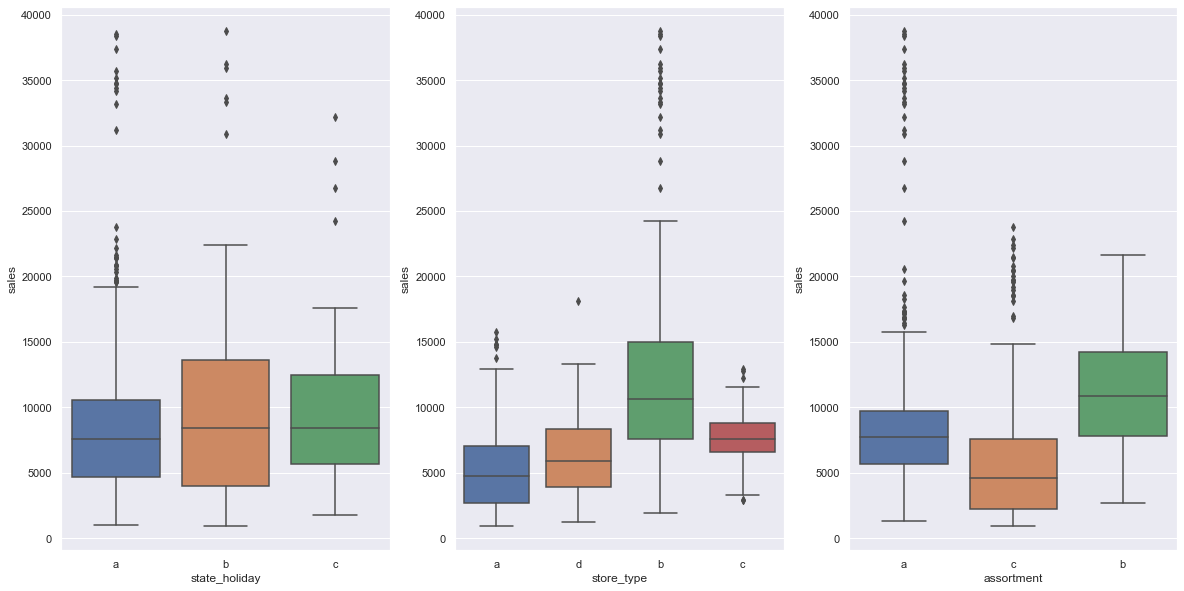

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.boxplot(data=aux1, x='state_holiday', y='sales')

plt.subplot(1,3,2)
sns.boxplot(data=aux1, x='store_type', y='sales')

plt.subplot(1,3,3)
sns.boxplot(data=aux1, x='assortment', y='sales');

# 2.0 Criação de Novos Atributos
Feature Engineering

In [17]:
# Faz uma copia do dataset
df2 = df1.copy()

In [18]:
# Criação dos novos atributos

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtragem de Variáveis

In [19]:
# Faz uma copia do dataset
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [20]:
# open  - Não podemos fazer previsões de vendas da loja se a loja estiver fechada, então vamos trabalhar apenas com as lojas abertas.
# sales - Quando a loja está fechada tenho venda 0. Vamos trabalhar apenas com lojas que tiveram vendas.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção da Colunas

In [21]:
# customers      - esse dado não vai estar disponível na hora de fazer a previsão.
# open           - como vamos trabalhar apenas com as lojas abertas, não precisamos mais desta coluna.
# promo_interval - utilizamos esta coluna para derivar a coluna is_promo 
# month_map      - coluna criada para auxiliar na criação da coluna is_promo 

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória de Dados

In [22]:
df4 = df3.copy()

## 4.1 Mapa Mental de Hipóteses

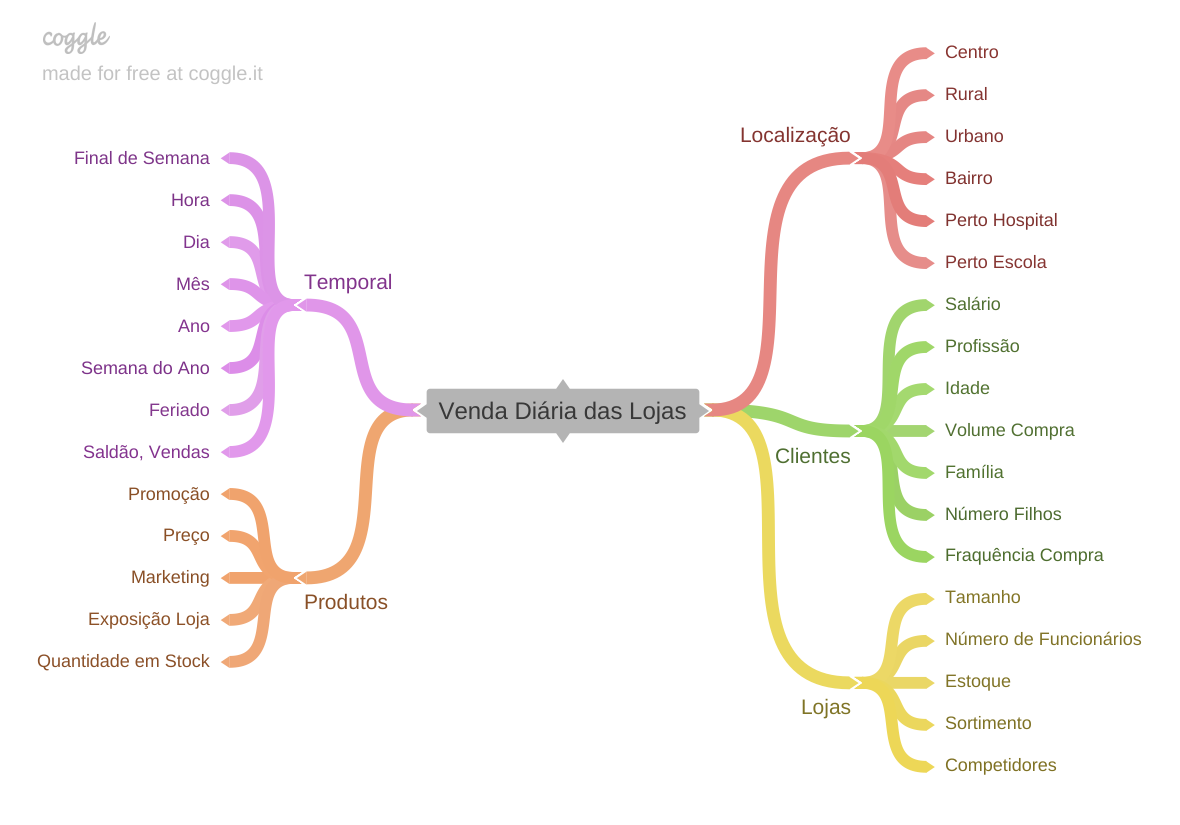

In [23]:
Image('img/Mapa_Mental_de_Hipóteses.png')

## 4.2 Criação das Hipóteses

### 4.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 4.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoções deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 4.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 4.2.4 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender menos durante os feriados escolares.

## 4.3 Análise Univariada

### 4.3.1 Variável Resposta

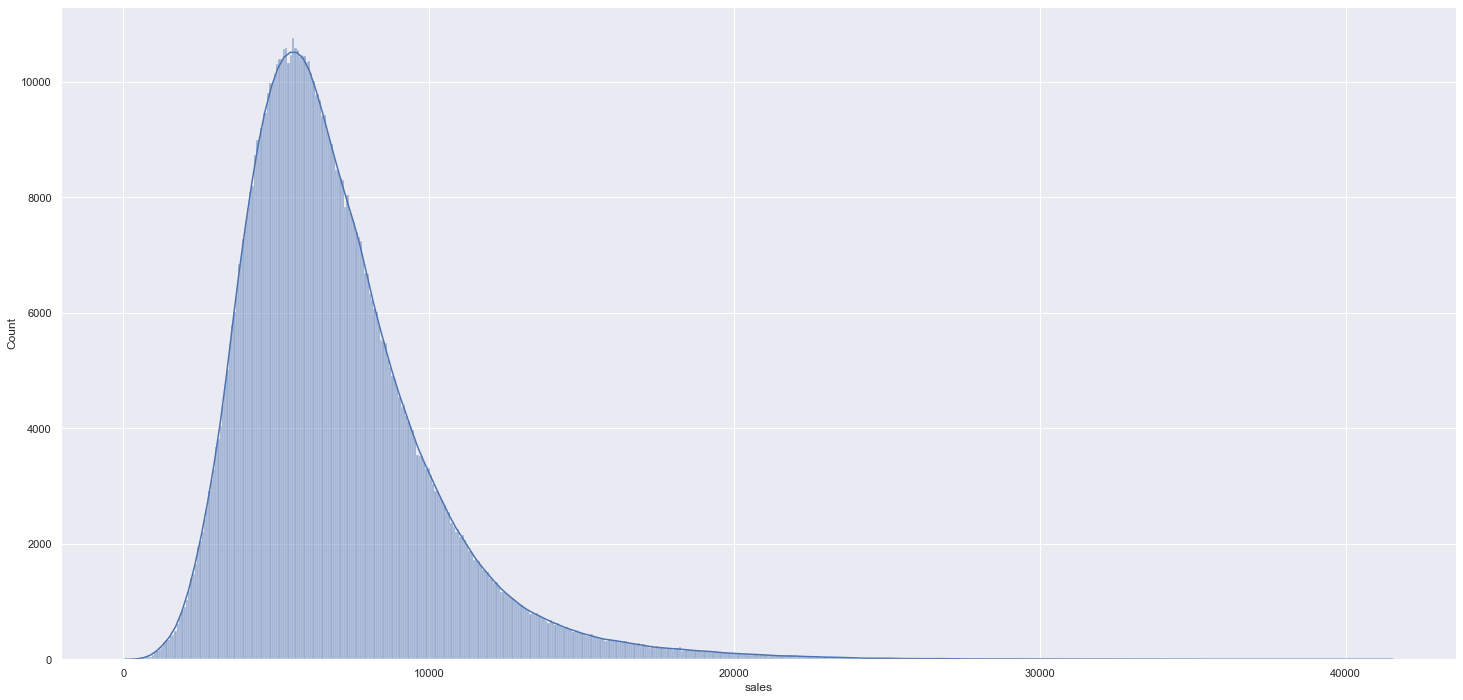

In [24]:
sns.histplot(df4['sales'], kde=True);

### 4.3.2 Variáveis Numéricas

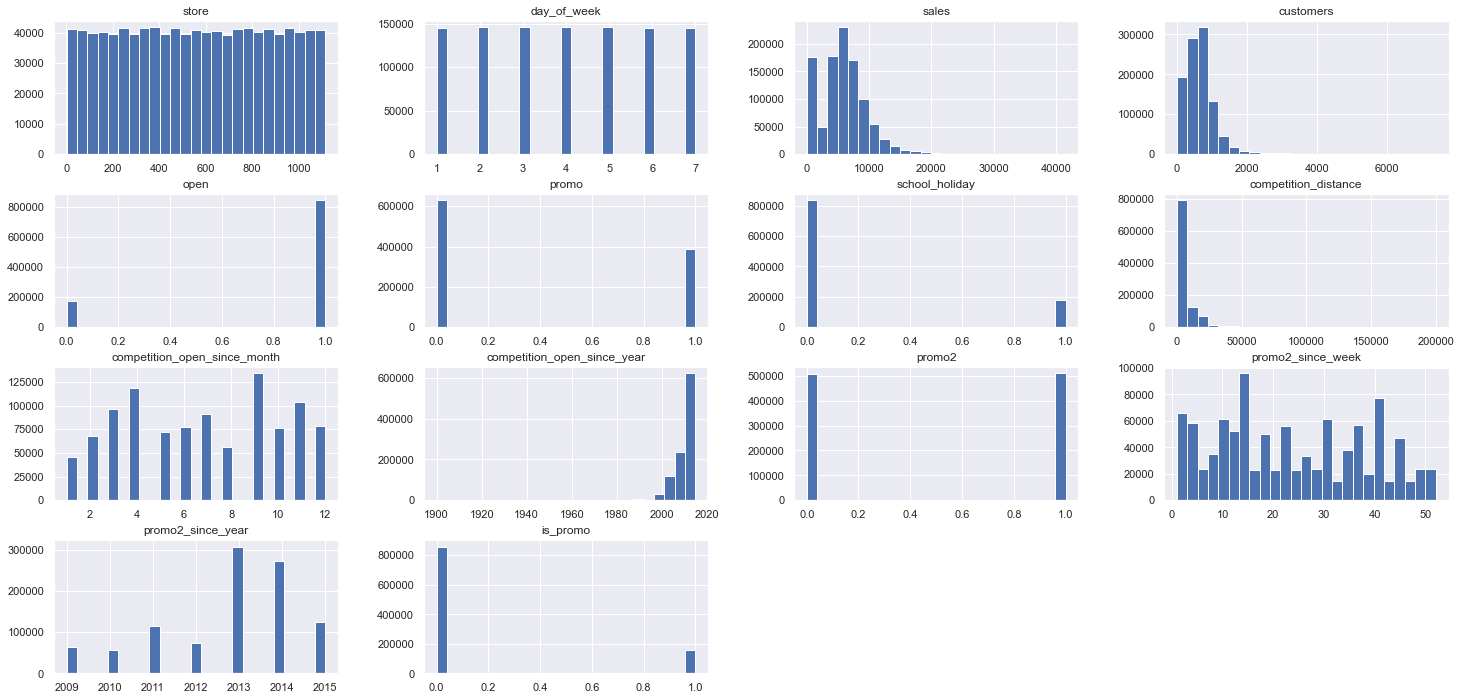

In [25]:
num_attributes.hist(bins=25);

### 4.3.3 Variáveis Categóricas

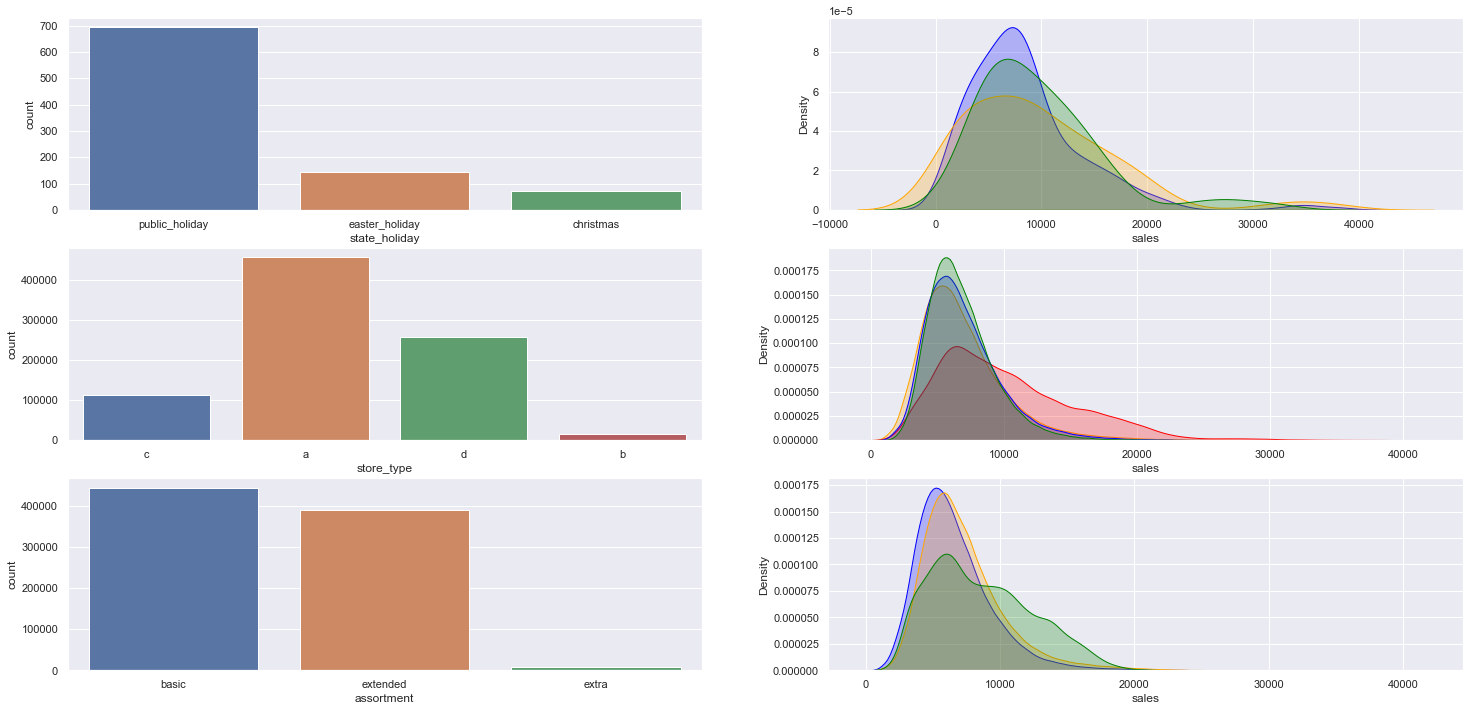

In [26]:
# state_holiday

plt.subplot(3,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=aux, x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(aux[aux['state_holiday'] == 'public_holiday']['sales'], shade=True, color='blue')
sns.kdeplot(aux[aux['state_holiday'] == 'easter_holiday']['sales'], shade=True, color='orange')
sns.kdeplot(aux[aux['state_holiday'] == 'christmas']['sales'], shade=True, color='green')

# store_type
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade=True, color='orange')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade=True, color='red')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade=True, color='blue')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade=True, color='green')

# assortment
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True, color='blue')
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade=True, color='orange')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True, color='green');

**state_holiday**: Como podemos ver public_holiday tem um número muito maior de vendas, mas suas vendas estão mais concentradas em valores menores que os valores de easter_holiday e christmas.

**store_type**: A loja do tipo b tem um número bem pequeno de vendas, mas suas vendas tem um valor maior que do outros tipos de loja.

**assortment**: Os sortimentos basic e extended tem uma quantidade parecida de vendas e de valores. Se comparados ao sortimento extra, os dois primeiros tem um número muito maior de vendas mas a concentração de valores por venda é menor.

## 4.4 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.

**VERDADEIRA** - Lojas com sortimento extra vendem mais.

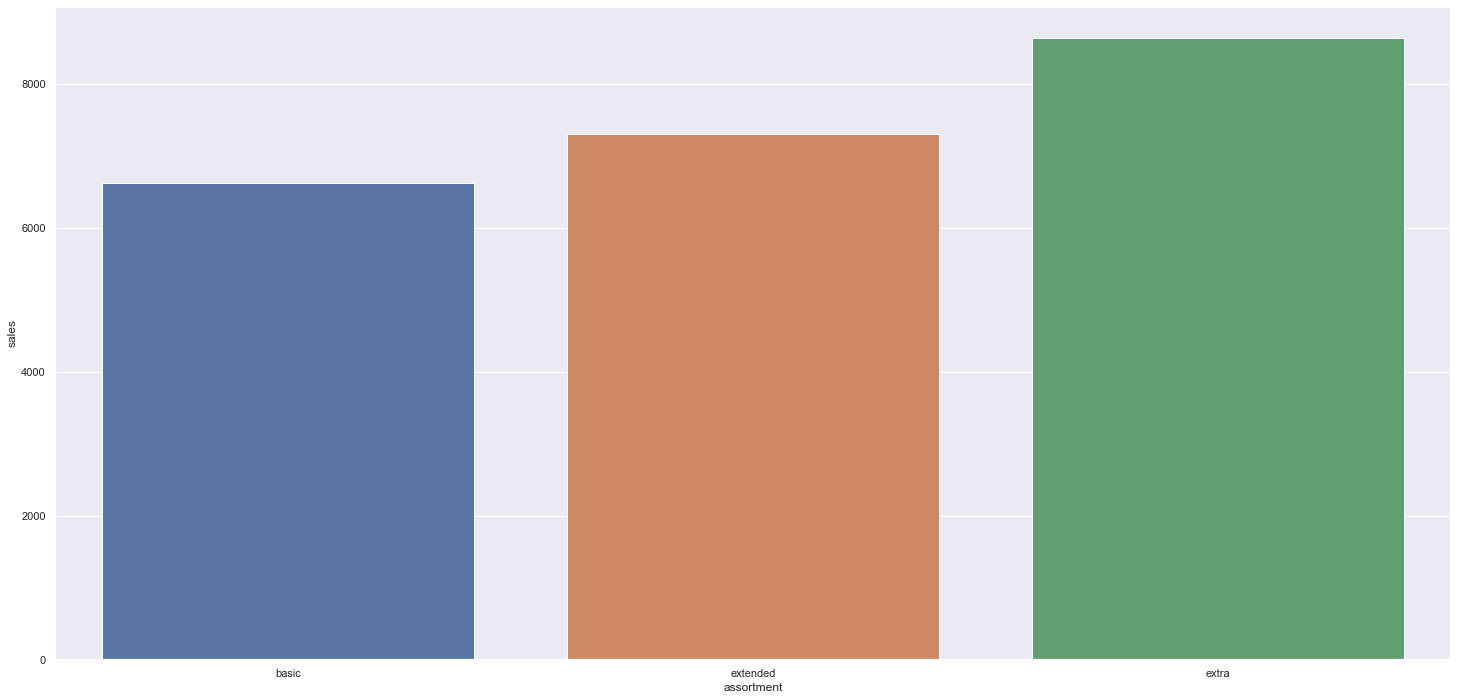

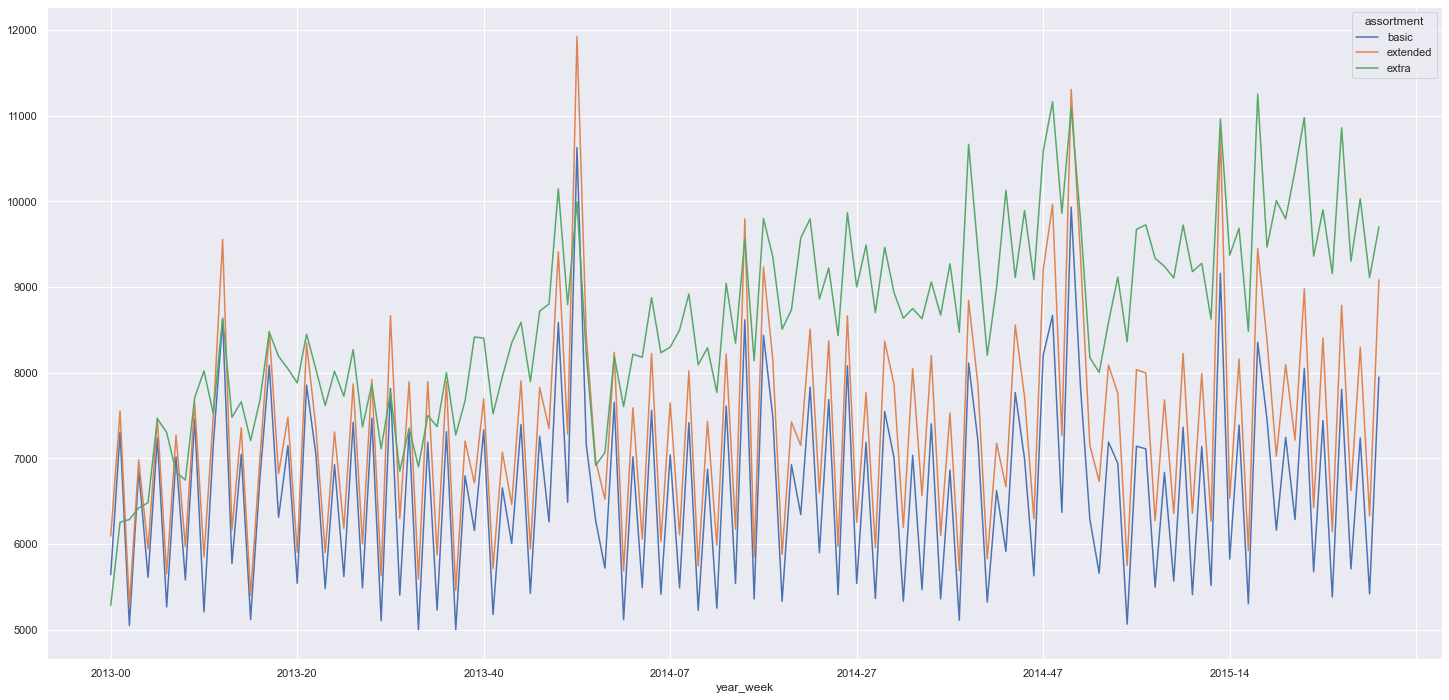

In [27]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** - Lojas com competidores mais próximos vendem mais.

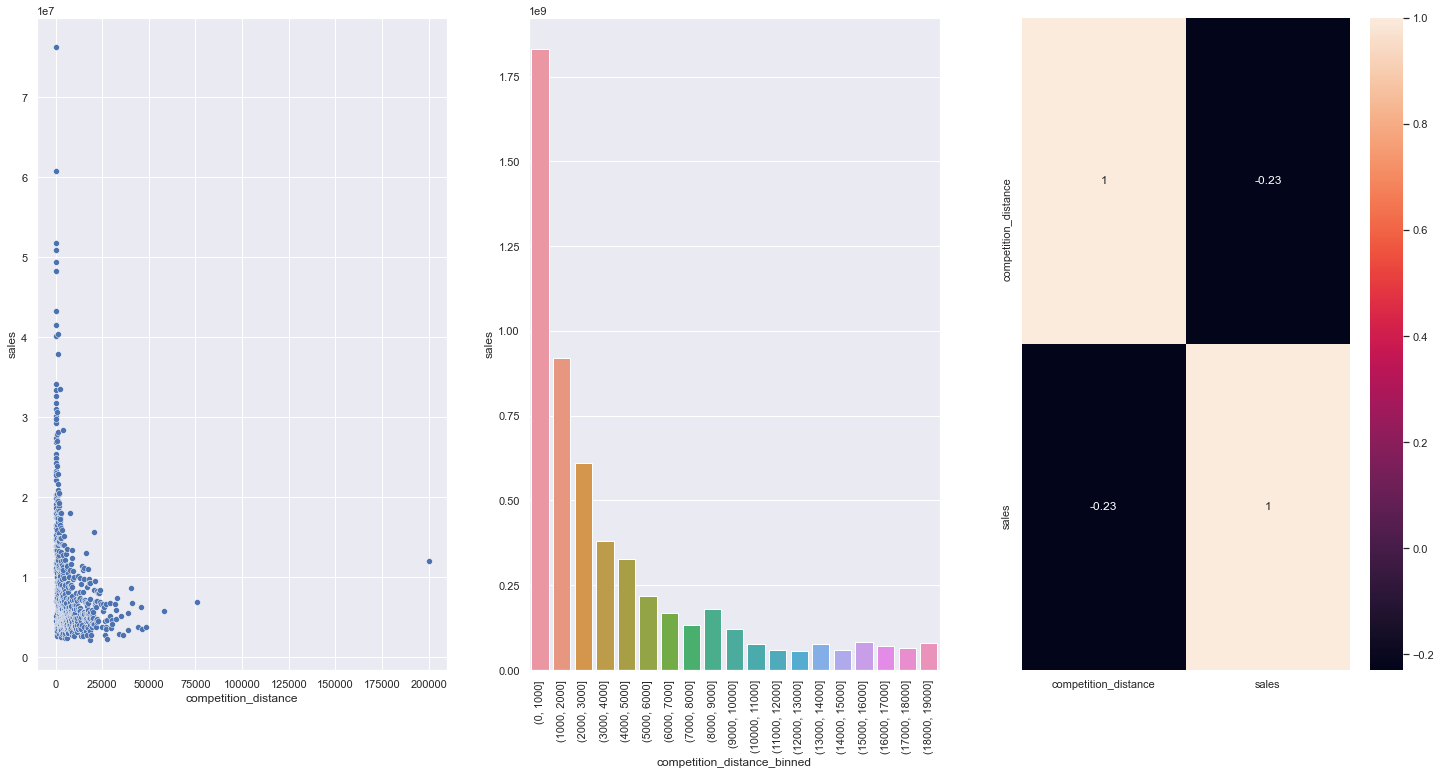

In [28]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(data=aux1, x='competition_distance', y='sales');

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** - Lojas com competidores a mais tempo vendem menos.

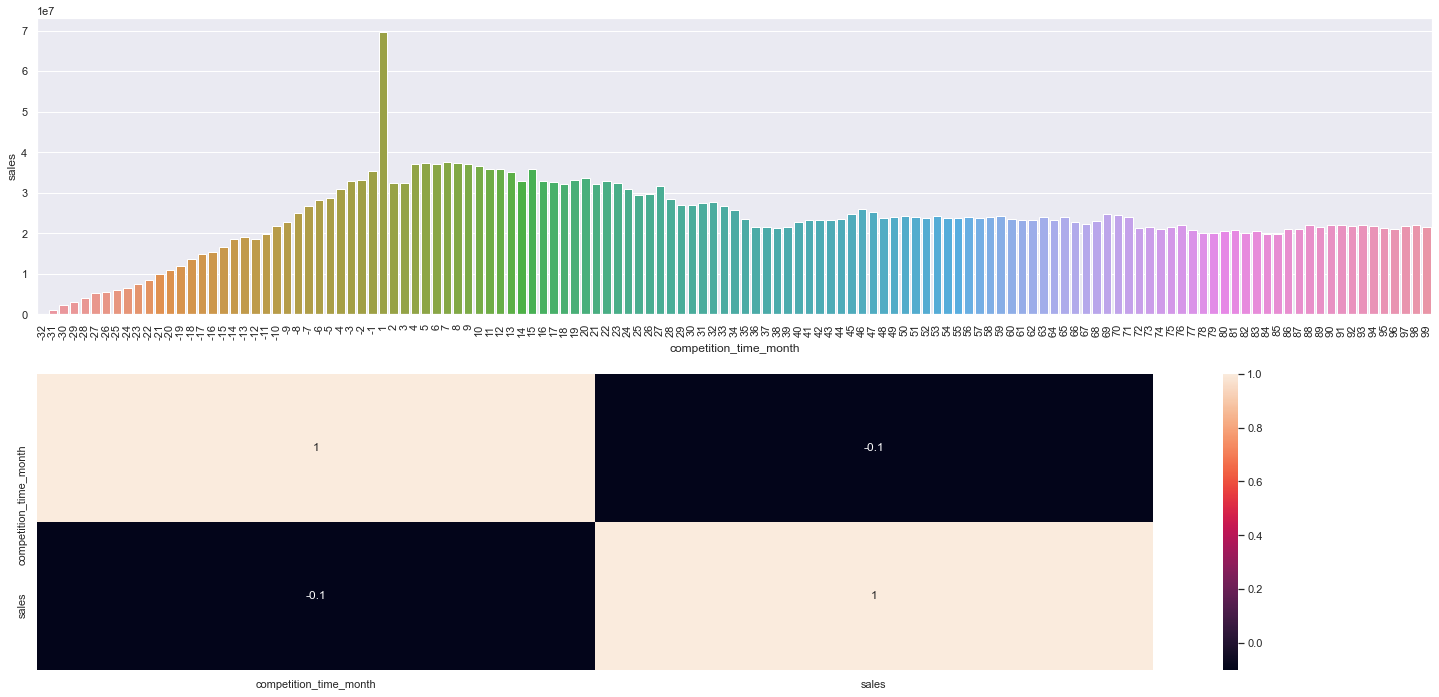

In [29]:
plt.subplot(2,1,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 100) & (aux1['competition_time_month'] != 0)]
sns.barplot(data=aux2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

plt.subplot(2,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

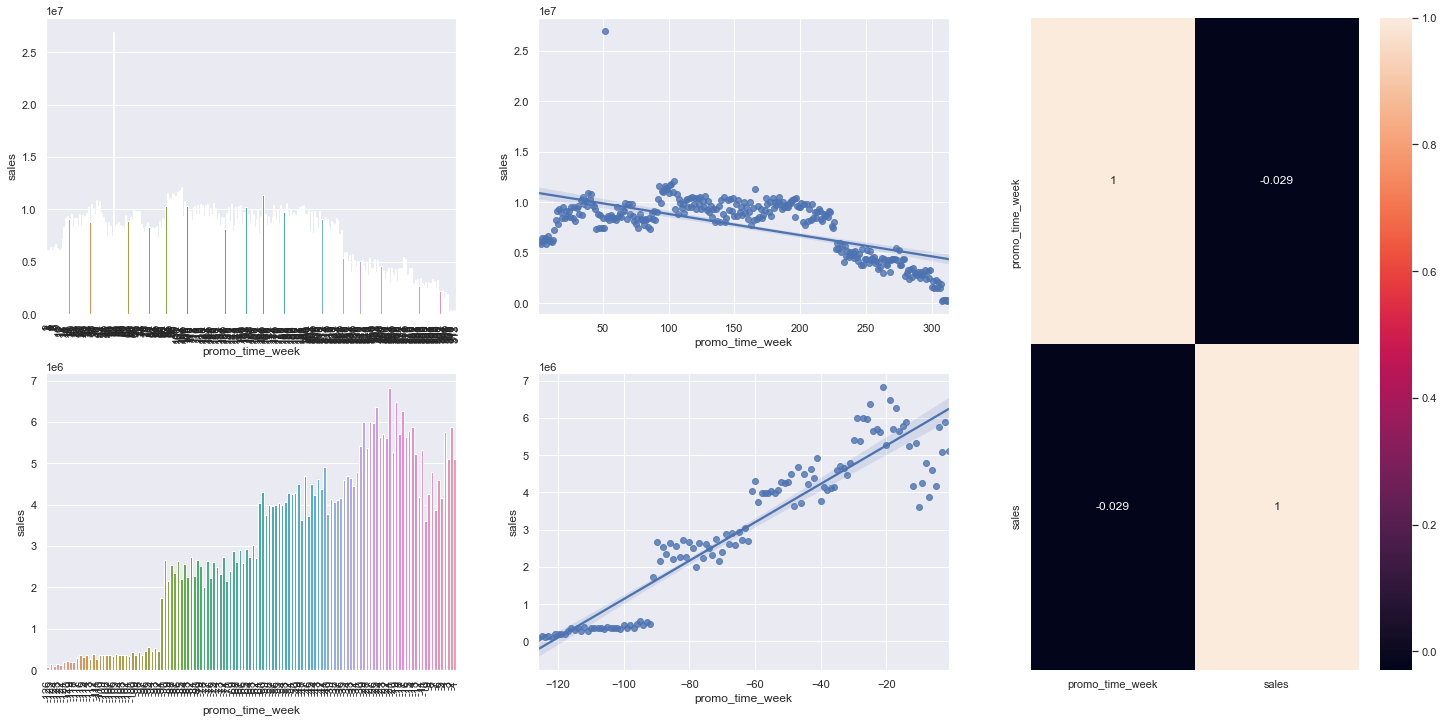

In [30]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
sns.barplot(data=aux2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales');

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H5.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** - Lojas com mais promoções consecutivas vendem menos.

In [31]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


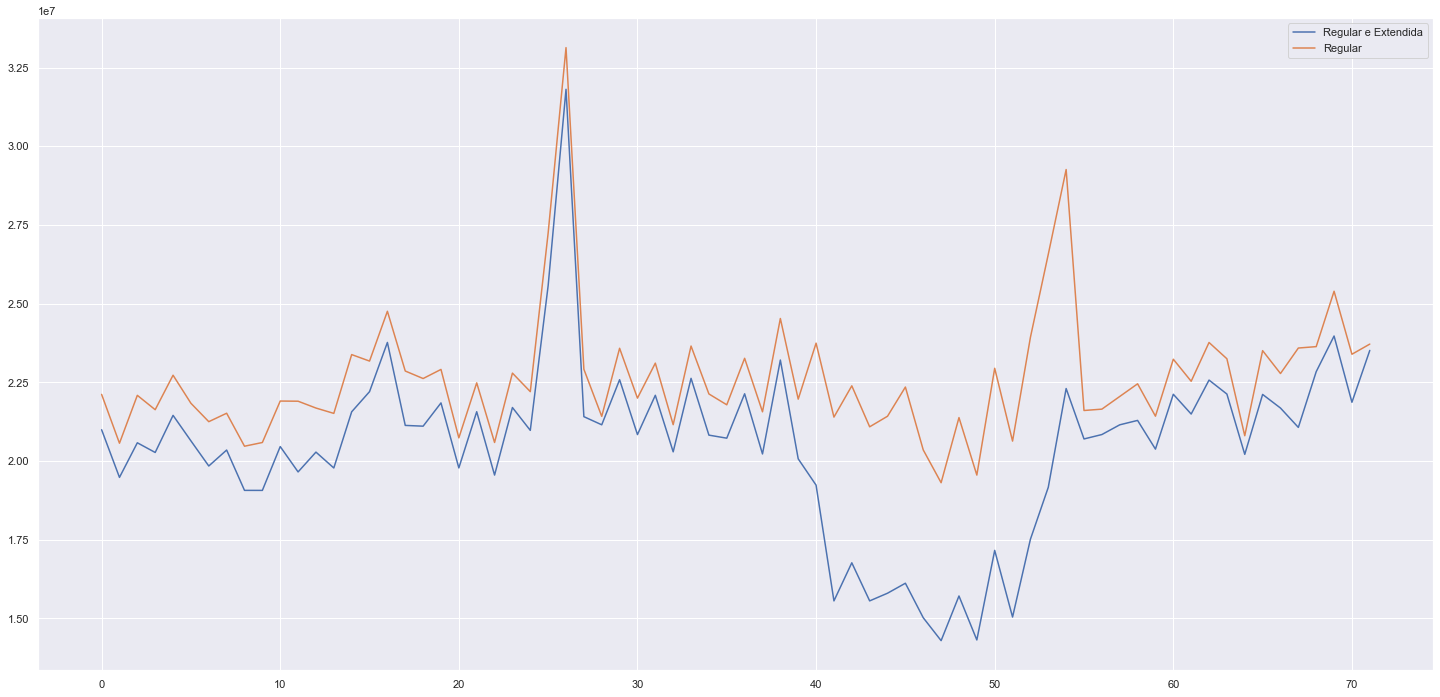

In [32]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Regular e Extendida', 'Regular'])

### **H6.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas abertas durante o feriado de natal vedem menos.

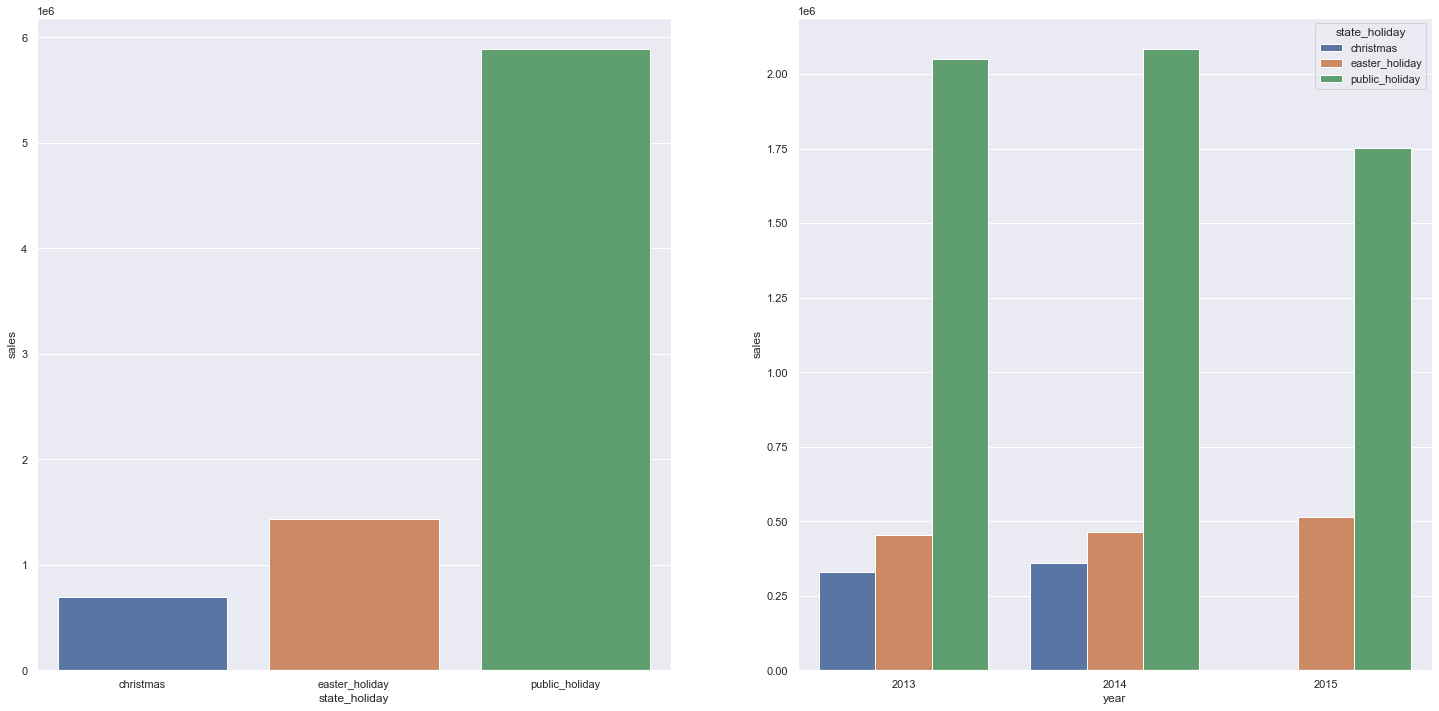

In [33]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales');

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday');

### **H7.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** - Lojas vendem menos ao longo dos anos.

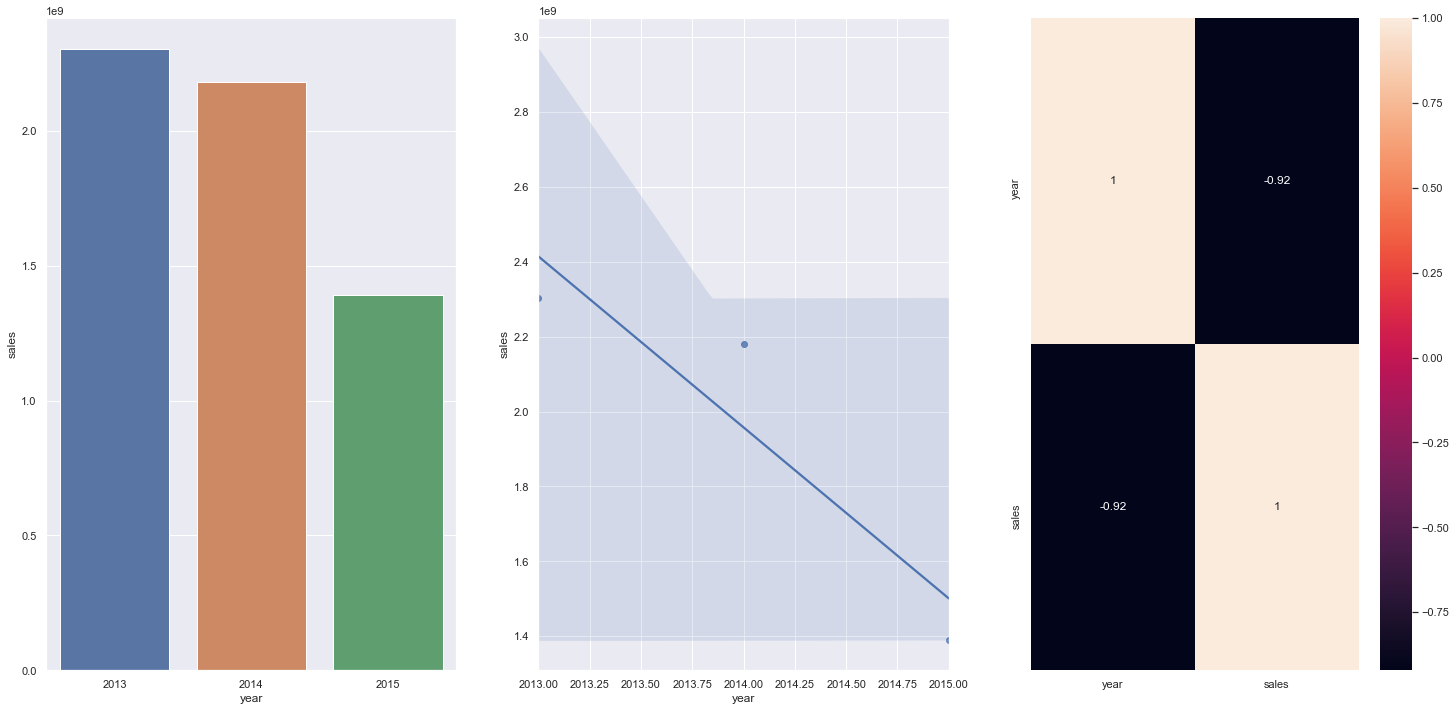

In [34]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H8.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** - Lojas vendem menos no segundo semestre do ano.

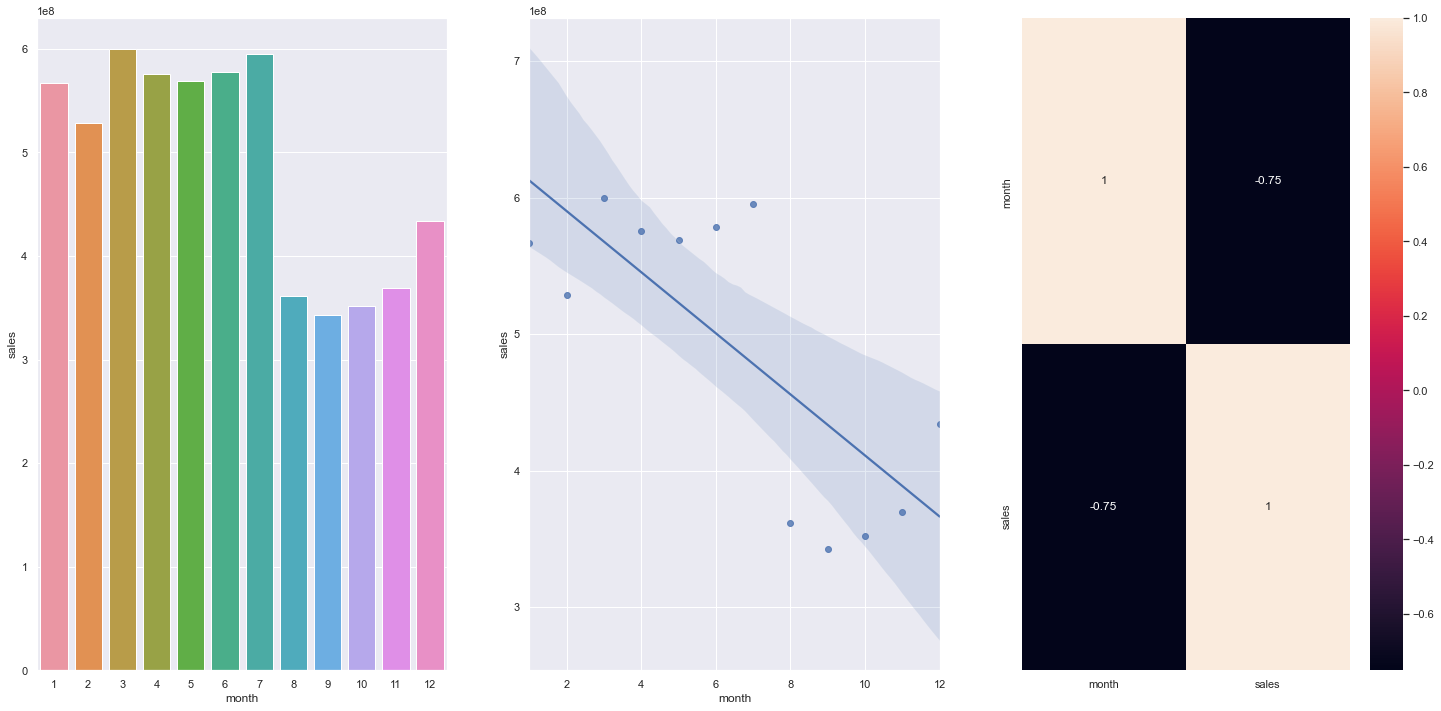

In [35]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** - Lojas vendem mais depois do dia 10 de cada mês.

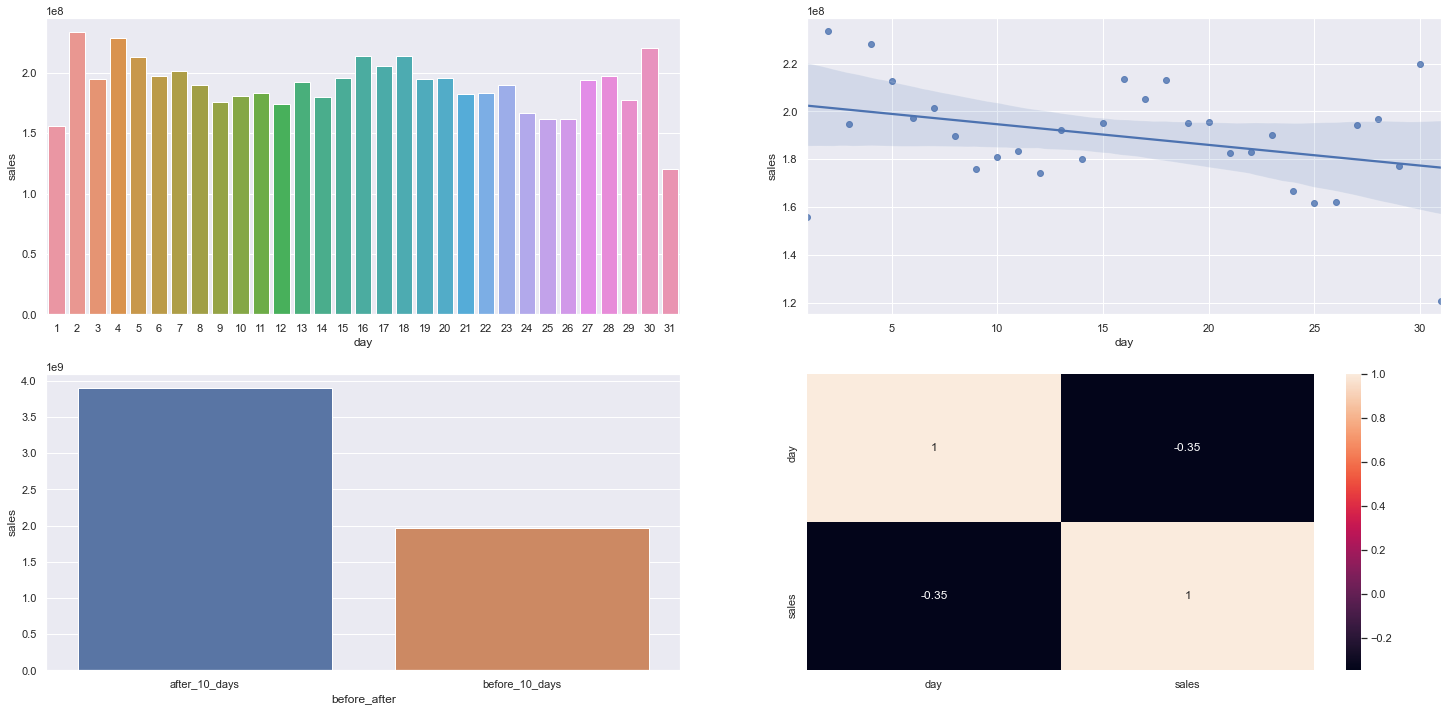

In [36]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,3)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=aux2, x='before_after', y='sales');

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** - Lojas vendem menos no final de semana.

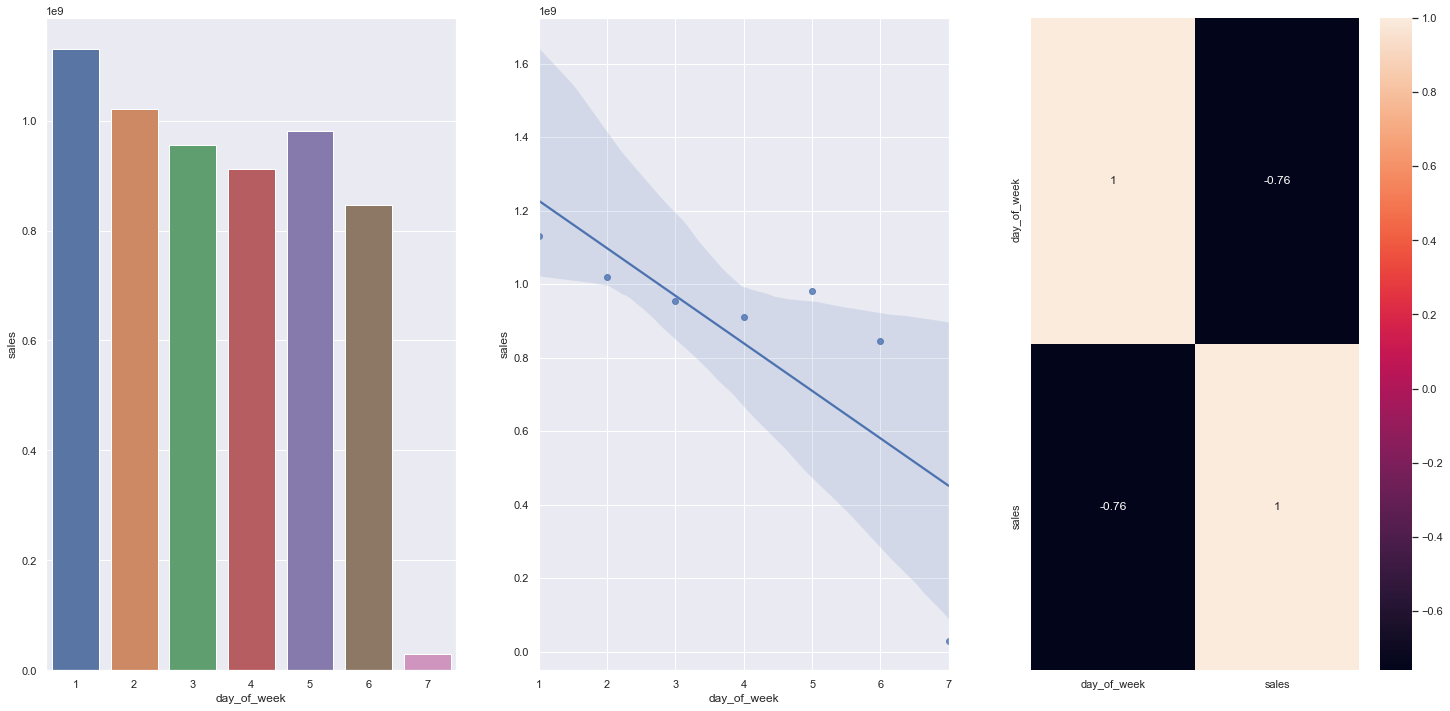

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H11.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** - Lojas vendem menos durante os feriados escolares, exceto no mês de agosto.

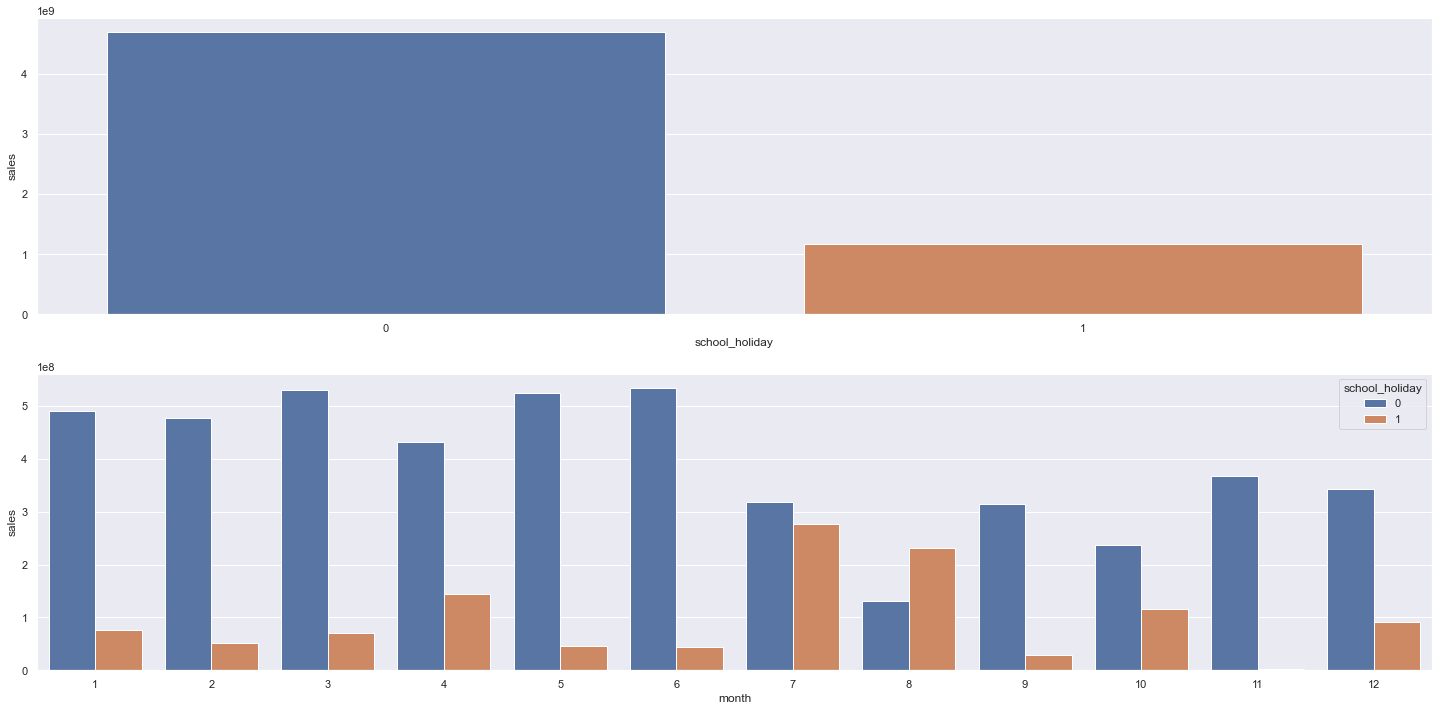

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(data=aux1, x='school_holiday', y='sales');

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');

## 4.5 Análise Multivariada

### 4.5.1 Variáveis Numéricas

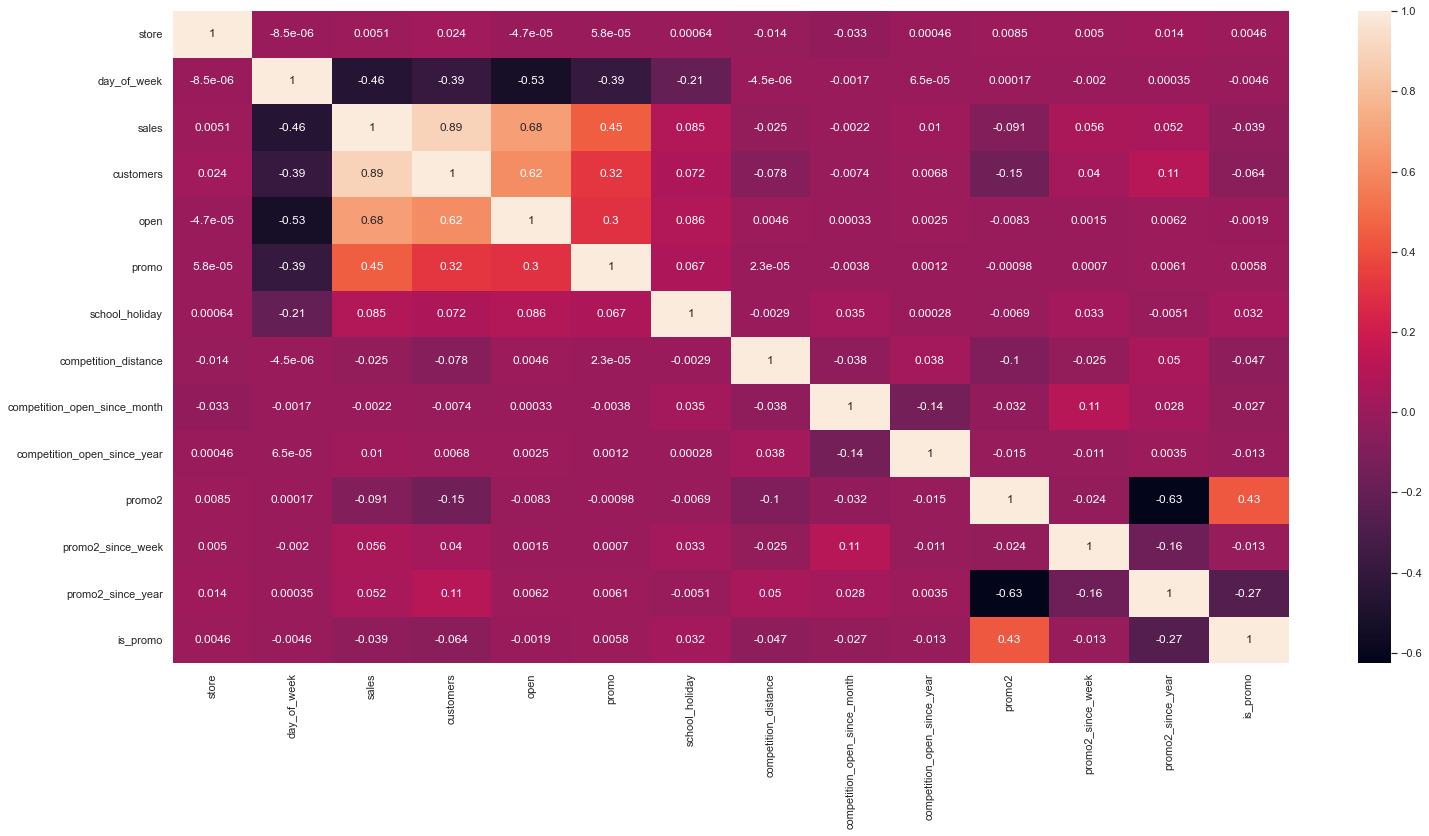

In [39]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True);

### 4.5.2 Variáveis Categóricas

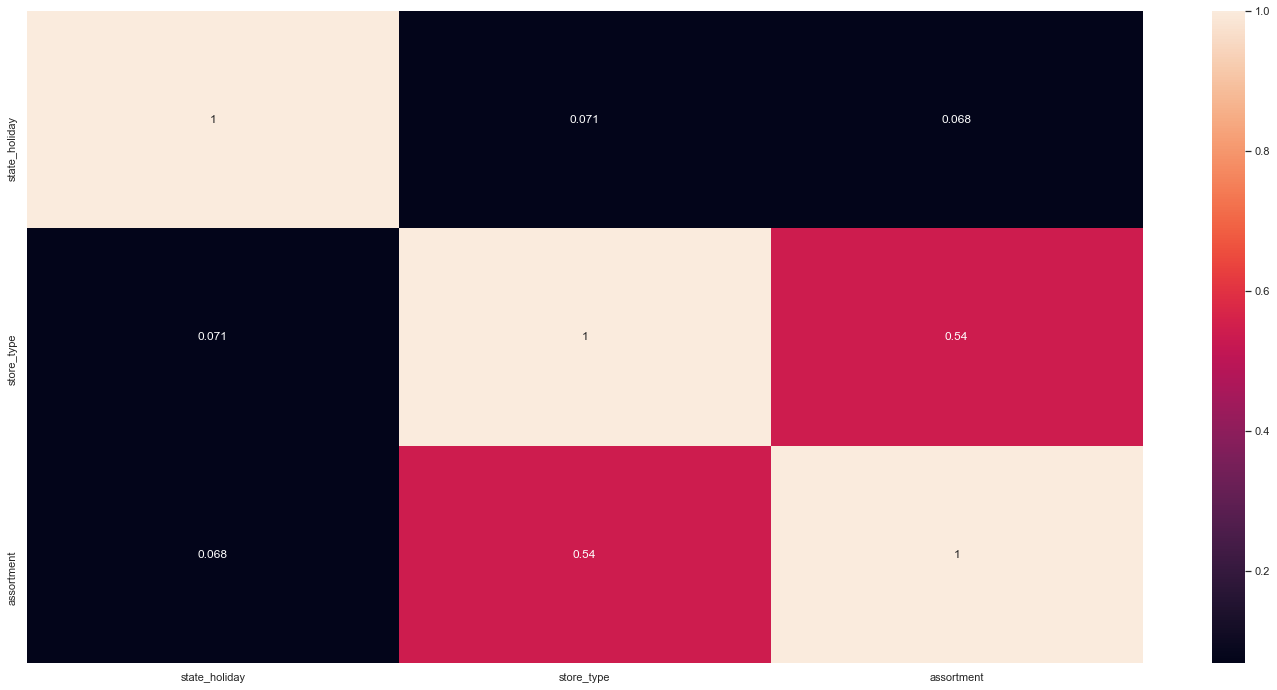

In [40]:
df_cat = df4.select_dtypes(include='object')

corr1 = cramer_v(df_cat['state_holiday'], df_cat['state_holiday'])
corr2 = cramer_v(df_cat['state_holiday'], df_cat['store_type'])
corr3 = cramer_v(df_cat['state_holiday'], df_cat['assortment'])

corr4 = cramer_v(df_cat['store_type'], df_cat['state_holiday'])
corr5 = cramer_v(df_cat['store_type'], df_cat['store_type'])
corr6 = cramer_v(df_cat['store_type'], df_cat['assortment'])

corr7 = cramer_v(df_cat['assortment'], df_cat['state_holiday'])
corr8 = cramer_v(df_cat['assortment'], df_cat['store_type'])
corr9 = cramer_v(df_cat['assortment'], df_cat['assortment'])

df_corr = pd.DataFrame({'state_holiday': [corr1,corr2,corr3],
                        'store_type':    [corr4,corr5,corr6],
                        'assortment':    [corr7,corr8,corr9]})
df_corr = df_corr.set_index(df_corr.columns)
sns.heatmap(df_corr, annot=True);

# 5.0 Preparação dos Dados

In [41]:
df5 = df4.copy()

## 5.1 Reescala

In [42]:
rs = RobustScaler()  ### Utilizado em atributos com outliers bem definidos
mms = MinMaxScaler() ### Utilizado em atributos sem outliers ou com outliers não muito significativos

In [43]:
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('webapp/parametro/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('webapp/parametro/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('webapp/parametro/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('webapp/parametro/year_scaler.pkl', 'wb'))

## 5.2 Transformação

### 5.2.1 Encoding

In [44]:
# state_holiday
ohe = OneHotEncoder(cols=['state_holiday'], use_cat_names=True)
df5 = ohe.fit_transform(df5)
pickle.dump(ohe, open('webapp/parametro/state_holiday_scaler.pkl', 'wb'))

# store_type
oe = OrdinalEncoder(cols=['store_type'])
df5 = oe.fit_transform(df5)
pickle.dump(oe, open('webapp/parametro/store_type_scaler.pkl', 'wb'))

# assortment
df5['assortment'] = df5['assortment'].map({'basic': 1, 'extra': 2, 'extended': 3})

D:\anaconda3\envs\previsao_rossmann\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### 5.2.2 Transformação da Variável Responsta

In [45]:
df5['sales'] = np.log1p(df5['sales'])

### 5.2.3 Transformação de Natureza

In [46]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 Seleção de Variáveis

In [47]:
df6 = df5.copy()

## 6.1 Divisão dos Dados em Treino e Teste

In [48]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [49]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [50]:
# dados de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dados de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta - Selecionando as Variáveis

In [51]:
## trieno e teste para boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## definição RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
## boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Boruta - Melhores Variáveis 

In [52]:
#cols_selected = boruta.support_
#
## melhores variáveis
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## variáveis nao selecionadas
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

Como o Boruta demora bastante para rodar (no caso deste projeto demorou 4 horas), vamos anotar as melhores features e comentar esta parte do código para não precisarmos rodar este passo novamente.

### 6.2.2 Seleção de Variávies - Manual

In [53]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos']

# Colunas para adicionar 
feat_to_add = ['date','sales']

# Lista final
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

Anotamos as melhores features que o Boruta apontou e adicionamos mais alguns que vimos na **Análise Exploratória** que seriam importantes para a criação do modelo. 

# 7.0 Modelos de Machine Learning

In [54]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Preparação dos Dados - Time Series
x_training = X_train[cols_selected_boruta_full]

## 7.1 Média

In [55]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predição
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression

In [56]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# predição
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1866.264552,0.291983,2668.205929


### 7.2.1 Linear Regression - Validação Cruzada

In [57]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2079.85 +/- 293.45,0.3 +/- 0.02,2946.48 +/- 466.62


## 7.3 Linear Regression Regularized

In [58]:
# modelo
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# predição
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.069333,0.288966,2743.477536


### 7.3.1 Linear Regression Regularized - Validação Cruzada

In [59]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,2115.98 +/- 341.49,0.29 +/- 0.01,3057.55 +/- 503.86


## 7.4 Random Forest Regressor

In [60]:
# modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# predição
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,710.019805,0.106141,1045.24329


### 7.4.1 Random Forest Regressor - Validação Cruzada

In [61]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,861.72 +/- 227.84,0.12 +/- 0.02,1298.14 +/- 328.4


## 7.5 XGBoost Regressor

In [62]:
# modelo
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.2,
                             max_depth=10, 
                             subsample=0.5,
                             colsample_bytree=0.9).fit(x_train, y_train)

# predição
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,709.249946,0.103972,1028.739368


### 7.5.1 XGBoost Regressor - Validação Cruzada

In [63]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,901.4 +/- 134.93,0.13 +/- 0.01,1284.6 +/- 189.33


## 7.6 Comparação de Performance dos Modelos

### 7.6.1 Performance Única

In [64]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,709.249946,0.103972,1028.739368
0,Random Forest Regressor,710.019805,0.106141,1045.243290
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1866.264552,0.291983,2668.205929
0,Linear Regression - Lasso,1891.069333,0.288966,2743.477536


### 7.6.2 Performance Real - Validação Cruzada

In [65]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2079.85 +/- 293.45,0.3 +/- 0.02,2946.48 +/- 466.62
0,Linear Regression - Lasso,2115.98 +/- 341.49,0.29 +/- 0.01,3057.55 +/- 503.86
0,Random Forest Regressor,861.72 +/- 227.84,0.12 +/- 0.02,1298.14 +/- 328.4
0,XGBoost Regressor,901.4 +/- 134.93,0.13 +/- 0.01,1284.6 +/- 189.33


Como a Random Forest  e o XGBoost deram um resultado muito próximo, vamos continuar com o **XGBoost** já que ele é um modelo mais leve.

# 8.0 Ajuste dos Hiperparâmetros

## 8.1 Random Search

In [66]:
#param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.1, 0.2, 0.3],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.3, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]}

In [67]:
#MAX_EVAL = 10
#
#final_result = pd.DataFrame()
#import random
#
#for i in range(MAX_EVAL):
#    # escolhe os valores aleatoriamente
#    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#    print(hp)
#    
#    # modelo
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'], 
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#    
#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
#    
#final_result    

Como o Random Search demora bastante para rodar (no caso deste projeto demorou 7 horas), vamos anotar os melhores valores dos parametros e comentar esta parte do código para não precisarmos rodar este passo novamente.

## 8.2 Modelo Final 

In [68]:
param_tuned = {'n_estimators': 1700, 
               'eta': 0.1, 
               'max_depth': 9, 
               'subsample': 0.5, 
               'colsample_bytree': 0.9, 
               'min_child_weight': 15}

In [69]:
# modelo
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'], 
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# predição
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,665.614354,0.096652,969.334391


In [70]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe # Subestimando o erro (o valor predito tende a ser menor que o valor real.)

0.003719369496799579

In [71]:
# Salva o modelo treinado
pickle.dump(model_xgb_tuned, open('webapp/modelo/modelo_rossmann.pkl', 'wb'))

# 9.0 Tradução e Interpretação do Erro

In [74]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Machine Learning Performance

In [75]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

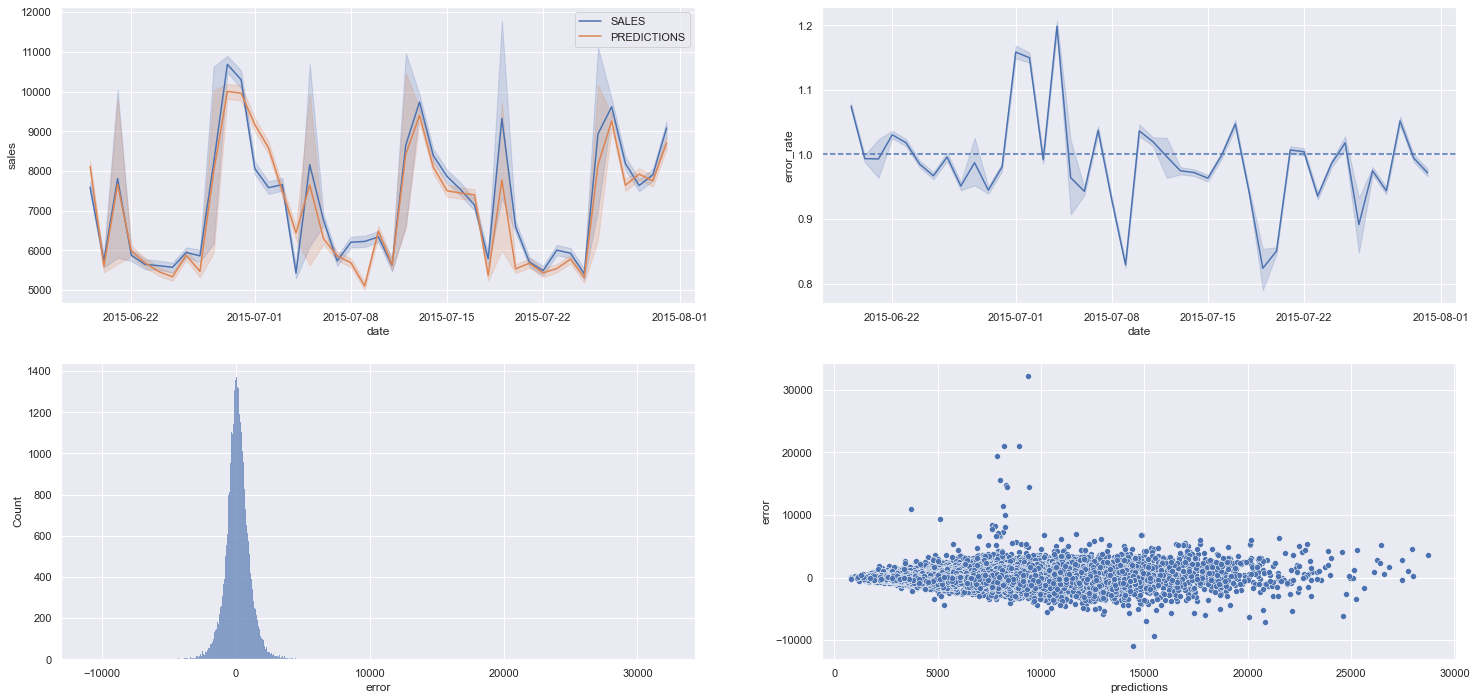

In [76]:
plt.subplot(2,2,1)
sns.lineplot(data=df9, x='date', y='sales', label='SALES');
sns.lineplot(data=df9, x='date', y='predictions', label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(data=df9, x='date', y='error_rate');
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.histplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(data=df9, x='predictions', y='error');

## 9.2 Performance do Negócio

In [77]:
# Soma das predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordenando Colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [78]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
208,209,233649.359375,232754.806797,234543.911953,894.552578,0.133129
70,71,337024.500000,336264.997783,337784.002217,759.502217,0.090923
705,706,217181.500000,216738.981802,217624.018198,442.518198,0.080329
381,382,275960.156250,275337.280722,276583.031778,622.875528,0.080054
112,113,214493.437500,213944.993243,215041.881757,548.444257,0.095348


Aqui podemos ver o número da loja, o valor que o modelo previu que seria vendido nas próximas 6 semanas, o **pior cenário** que pode ocorrer por loja, o **melhor cenário** que pode ocorrer por loja, a métrica **MAE** que diz o quanto o cenário pode flutuar por loja e a **MAPE** que diz o quanto o cenário pode flutuar em porcentagem por loja.

## 9.3 Performance Total

In [79]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$284,510,816.00"
1,worst_scenario,"R$283,764,524.79"
2,best_scenario,"R$285,257,130.38"


Como podemos ver no pior cenário venderemos um total de **R\$283.764.524,79** nas próximas 6 semanas, já no melhor cenário venderemos um de total de **R\$285.257.130,38**.

Assim que esses valores chegarem na diretoria da empresa o diretor geral vai poder decidir quanto investir na infra-estrutura de suas lojas.